In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import re
from catboost import Pool, CatBoostRanker

Даны два датасета: train, test (скачать по ссылке). \
Поля датасета: \

*   search_id - айди поиска (айди группы, которая связана с набором
объектов),
*   feature_0-78 - признаки этих объектов,
*   target - целевая переменная (допустим клик по этому объекту).

Задача:

*   обучить модель для релевантной выдачи (можно выбрать любой алгоритм, библиотеку или фреймворк),
*   посчитать метрику NDCG (для всех документов, не конкретного топа) на тестовом датасете,
*   выложить код на https://github.com отдельным проектом и поделиться ссылкой в поле для ответа.

Будет плюсом, если решение завернуть в docker.

In [227]:
train_df = pd.read_csv('/content/train_df.csv')

Исходя из условия задачи, считаю, что самым подходящим вариантом модели будет CatBoostRanker. Преимущества этой модели по моему мнению:

*   Решает задачи ранжирования, а у нас именно такая задача
*   По умолчанию считает мтерику NDCG, которую нам необходимо оптимизировать



# CatBoostRanker без предварительной обработки данных

Сначала обучим CatBoostRanker, никак не обрабатывая данные и не подбирая гиперпараметры. Это будет наш baseline.

In [256]:
def split_and_pool(train_df: pd.DataFrame, cat_cols=None) -> Pool:
    """
    Функция принимает на вход pd.DataFrame,
    разделяет данные на обучающую и валидационную выборки,
    помещает все в catboost.Pool и возвращает эти объекты
    """
    X = train_df.drop('target', axis=1)
    y = train_df['target']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    group_train = X_train['search_id'].values
    X_train.drop('search_id', axis=1, inplace=True)
    group_val = X_val['search_id'].values
    X_val.drop('search_id', axis=1, inplace=True)

    train_pool = Pool(data=X_train,
                    label = y_train,
                    group_id=group_train)

    eval_pool = Pool(data=X_val,
                    label = y_val,
                    group_id=group_val)

    if cat_cols:
        train_pool = Pool(data=X_train,
                          label = y_train,
                          group_id=group_train,
                          cat_features=cat_cols)

        eval_pool = Pool(data=X_val,
                         label = y_val,
                         group_id=group_val,
                         cat_features=cat_cols)

    return train_pool, eval_pool

In [229]:
train_pool, eval_pool = split_and_pool(train_df)

В параметрах укажем только оптимизацию по метрике NDCG и random_seed:

In [230]:
params = {
    'custom_metric': 'NDCG',
    'random_seed': 42
}

In [ ]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=eval_pool, verbose=False)

Проверим NDCG мтерику на тесте. В CatBoostRanker при вызове метода score() считается именно эта метрика.

In [260]:
test_df = pd.read_csv('test_df.csv')

In [234]:
group_test = test_df['search_id'].values
X_test = test_df.drop(['search_id', 'target'], axis=1)
y_test = test_df['target']

In [235]:
test_pool = Pool(X_test, y_test, group_id=group_test)
model.score(test_pool)

0.9306260723135041

**NDCG = 0.9306260723135041**

# Предобработка

Теперь попробуем добавить предобработку данных.

Первым делом посмотрим на пустые значения:

In [236]:
train_df.isna().sum().sum()

0

Если в признаке хранится только одно уникальное значение, то этот он бесполезен, избавимся от таких признаков:

In [237]:
drop_cols = []

In [238]:
def find_const_cols(df: pd.DataFrame, drop_cols: list) -> list:
    for col in df.columns:
        if (df[col].nunique() == 1):
            drop_cols.append(col)

    return drop_cols

In [239]:
drop_cols = find_const_cols(train_df, drop_cols)

Как видим, у нас 4 таких признака:

In [240]:
drop_cols

['feature_0', 'feature_73', 'feature_74', 'feature_75']

Посмотрим на матрицу корреляций:

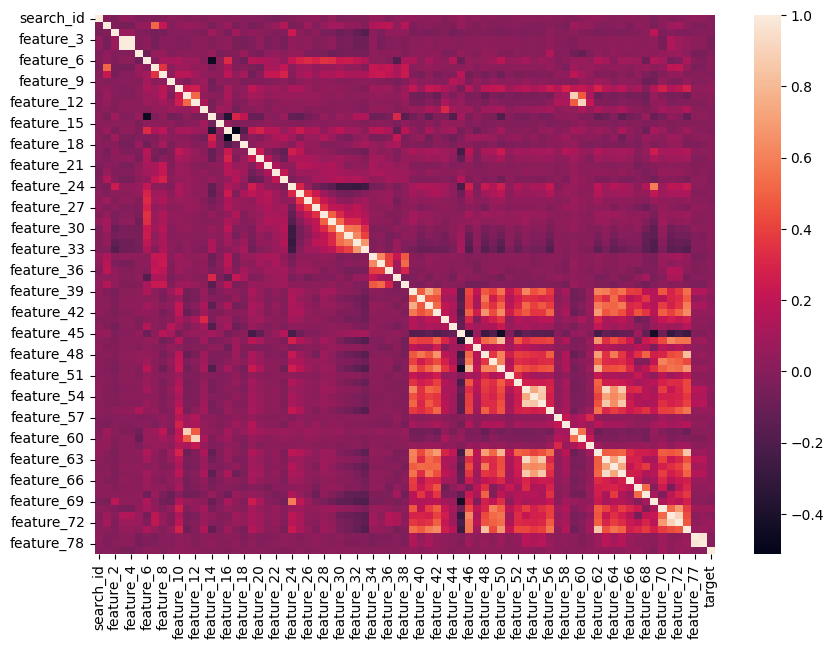

In [241]:
plt.figure(figsize=(10, 7))
sns.heatmap(train_df.drop(drop_cols, axis=1).corr());

Посмотрим на фичи, корреляция между которыми равна единице:

In [243]:
for col_i in train_df.columns:
    for col_j in train_df.columns:
        if ((np.corrcoef(train_df[col_i], train_df[col_j])[0, 1]) == 1) \
        and (col_i != col_j) \
        and (re.split('_', col_i)[-1] < re.split('_', col_j)[-1]):
            print("Сorrelation between", col_i, "and", col_j, " = 1")

Сorrelation between feature_3 and feature_4  = 1


Видим, что 3 и 4 фичи полностью коррелируют. Одну из них нужно удалить.

In [244]:
drop_cols.append('feature_4')

Удалим дубликаты:

In [246]:
train_df.drop_duplicates(inplace=True)

А теперь удалим ненужные фичи:

In [247]:
train_df.drop(drop_cols, axis=1, inplace=True)

Преполложем, что если в признаке меньше 30 уникальных значений и тип столбца integer, то этот признак категориальный.

In [248]:
def find_cat_cols(df: pd.DataFrame, n=30) -> list:
    cat_cols = []
    for col in df.drop('target', axis=1).columns:
        if (df[col].nunique() < n) and (df[col].dtypes == int):
            cat_cols.append(col)

    return cat_cols

In [249]:
cat_cols = find_cat_cols(train_df)

In [250]:
cat_cols

['feature_1',
 'feature_2',
 'feature_3',
 'feature_5',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15']

# CatBoostRanker с обработкой данных

Обучим модель, указав категориальные признаки:

In [257]:
train_pool, eval_pool = split_and_pool(train_df, cat_cols=cat_cols)

In [ ]:
model = CatBoostRanker(**params)
model.fit(train_pool, eval_set=eval_pool, verbose=False)

Проверим NDCG на тесте:

In [261]:
test_df.drop(drop_cols, axis=1, inplace=True)

In [262]:
group_test = test_df['search_id'].values
X_test = test_df.drop(['search_id', 'target'], axis=1)
y_test = test_df['target']

In [263]:
test_pool = Pool(X_test, y_test, group_id=group_test, cat_features=cat_cols)
model.score(test_pool)

0.892848366814504

Как видим, на тесте метрика упала. В черновике я пыталась по-разному комбинировать обратоку данных, но ничего не дало прироста в скоре. \
Исходя из этого могу лишь сделать вывод о том, что данные достаточно чистые и не требуют обработки. \
Также пробовала подбирать гиперпараметры, изменять лосс-функции, но скор только падал.